In [ ]:

"""
============================================================================
FOOTBALL MATCH SCORE PREDICTION PROJECT
============================================================================
Goal: Predict home and away team scores based on historical match data
Date: November 2025
Modle Used: XGXGBoost
============================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [16]:
"""
============================================================================
BLOCK 1: DATA LOADING AND INITIAL EXPLORATION
============================================================================
"""


# Load the pre-processed dataset
df = pd.read_csv("Dataset/SPL_raw_normalized.csv")

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Dataset Shape: {df.shape}")
print(f"Number of matches: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df[['home_score', 'away_score']].describe())
print("\nMissing Values (key columns):")
print(df[['home_score', 'away_score', 'date', 'home_team', 'away_team']].isnull().sum())


DATASET OVERVIEW
Dataset Shape: (3260, 17)
Number of matches: 3260
Date range: 2000-11-02 00:00:00 to 2018-05-04 00:00:00

First 5 rows:
   match_id       date   time    home_team  away_team  home_score  away_score  \
0       1.0 2000-11-02  20:00   Al-Ettifaq  Al Riyadh         1.0         0.0   
1       2.0 2000-11-02  20:00     Al Najma   Al-Nassr         0.0         1.0   
2       3.0 2000-11-03  20:00   Al Ahli SC   Al Ansar         3.0         0.0   
3       4.0 2000-11-07  20:00  Al Qadisiya      Sdoos         0.0         3.0   
4       5.0 2000-11-08  20:00     Al Wehda  Al-Shabab         1.0         0.0   

  stadium city round referee_name  attendance season_label  season_start_year  \
0     NaN  NaN   NaN          NaN         NaN    2000-2001               2000   
1     NaN  NaN   NaN          NaN         NaN    2000-2001               2000   
2     NaN  NaN   NaN          NaN         NaN    2000-2001               2000   
3     NaN  NaN   NaN          NaN         NaN    200


EXPLORATORY DATA ANALYSIS

Score Statistics:
Average Home Score: 1.57
Average Away Score: 1.34
Max Home Score: 10.0
Max Away Score: 8.0

Match Results Distribution:
result
Home Win    1395
Away Win    1039
Draw         826
Name: count, dtype: int64

Home Win Rate: 42.79%


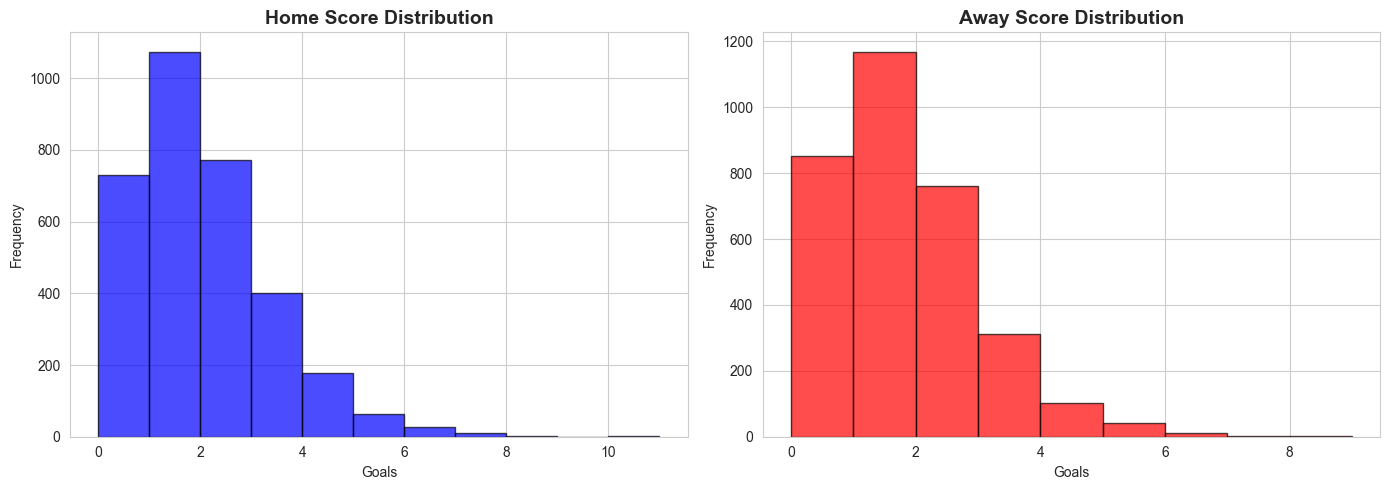

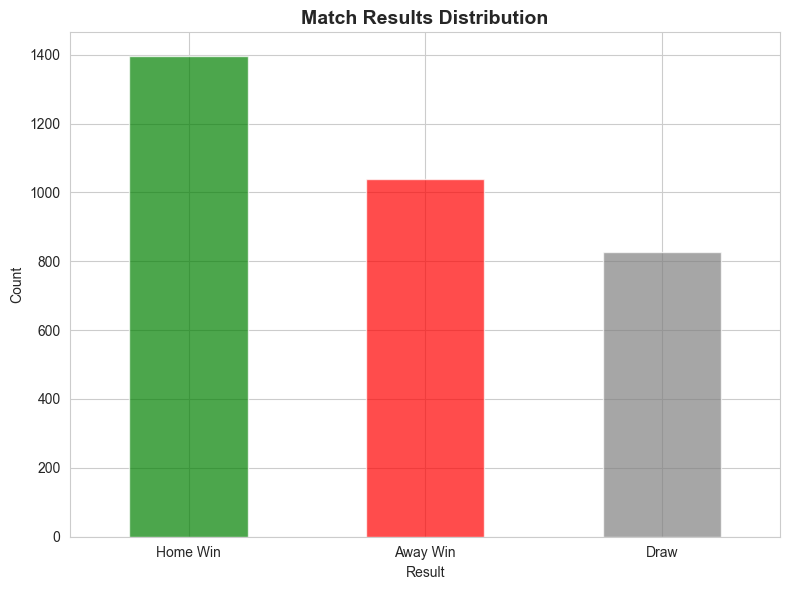

In [17]:
"""
============================================================================
BLOCK 3: EXPLORATORY DATA ANALYSIS (EDA)
============================================================================
"""

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Score distribution
print("\nScore Statistics:")
print(f"Average Home Score: {df['home_score'].mean():.2f}")
print(f"Average Away Score: {df['away_score'].mean():.2f}")
print(f"Max Home Score: {df['home_score'].max()}")
print(f"Max Away Score: {df['away_score'].max()}")

# Match result distribution
df['result'] = df.apply(lambda row: 'Home Win' if row['home_score'] > row['away_score'] 
                        else ('Away Win' if row['home_score'] < row['away_score'] else 'Draw'), axis=1)
print("\nMatch Results Distribution:")
print(df['result'].value_counts())
print(f"\nHome Win Rate: {(df['result'] == 'Home Win').sum() / len(df) * 100:.2f}%")

# Visualization 1: Score Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['home_score'], bins=range(0, int(df['home_score'].max())+2), 
             alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Home Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Goals')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['away_score'], bins=range(0, int(df['away_score'].max())+2), 
             alpha=0.7, color='red', edgecolor='black')
axes[1].set_title('Away Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Goals')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Visualization 2: Match Results
plt.figure(figsize=(8, 6))
df['result'].value_counts().plot(kind='bar', color=['green', 'red', 'gray'], alpha=0.7)
plt.title('Match Results Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Result')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
"""
============================================================================
BLOCK 4: FEATURE ENGINEERING
============================================================================
"""

print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

def calculate_team_stats(df):
    """
    Calculate rolling statistics for each team
    Returns a dictionary with team stats
    """
    team_stats = {}
    
    # Get all unique teams
    all_teams = set(df['home_team'].unique()) | set(df['away_team'].unique())
    
    for team in all_teams:
        # Get all matches for this team (up to current match)
        home_matches = df[df['home_team'] == team].copy()
        away_matches = df[df['away_team'] == team].copy()
        
        total_matches = len(home_matches) + len(away_matches)
        
        if total_matches > 0:
            # Goals scored
            goals_scored = home_matches['home_score'].sum() + away_matches['away_score'].sum()
            # Goals conceded
            goals_conceded = home_matches['away_score'].sum() + away_matches['home_score'].sum()
            
            # Calculate attack and defense strength
            attack_strength = goals_scored / total_matches if total_matches > 0 else 0
            defense_strength = goals_conceded / total_matches if total_matches > 0 else 0
            
            # Win rate
            home_wins = len(home_matches[home_matches['home_score'] > home_matches['away_score']])
            away_wins = len(away_matches[away_matches['away_score'] > away_matches['home_score']])
            win_rate = (home_wins + away_wins) / total_matches if total_matches > 0 else 0
            
            team_stats[team] = {
                'attack': attack_strength,
                'defense': defense_strength,
                'win_rate': win_rate,
                'matches': total_matches
            }
    
    return team_stats

print("Calculating team statistics...")
team_stats = calculate_team_stats(df)

# Add team statistics as features
df['Home_Attack_Strength'] = df['home_team'].map(lambda x: team_stats.get(x, {}).get('attack', 0))
df['Home_Defense_Strength'] = df['home_team'].map(lambda x: team_stats.get(x, {}).get('defense', 0))
df['Away_Attack_Strength'] = df['away_team'].map(lambda x: team_stats.get(x, {}).get('attack', 0))
df['Away_Defense_Strength'] = df['away_team'].map(lambda x: team_stats.get(x, {}).get('defense', 0))

# Calculate head-to-head statistics
print("Calculating head-to-head statistics...")
def calculate_h2h(df):
    """Calculate head-to-head win ratio for home team"""
    h2h_ratios = []
    
    for idx, row in df.iterrows():
        home = row['home_team']
        away = row['away_team']
        
        # Get previous matches between these teams
        previous_matches = df[
            (((df['home_team'] == home) & (df['away_team'] == away)) |
             ((df['home_team'] == away) & (df['away_team'] == home))) & 
            (df.index < idx)
        ]
        
        if len(previous_matches) > 0:
            # Count home team wins
            home_wins = len(previous_matches[
                ((previous_matches['home_team'] == home) & 
                 (previous_matches['home_score'] > previous_matches['away_score'])) |
                ((previous_matches['away_team'] == home) & 
                 (previous_matches['away_score'] > previous_matches['home_score']))
            ])
            h2h_ratio = home_wins / len(previous_matches)
        else:
            h2h_ratio = 0.5  # Neutral if no previous matches
        
        h2h_ratios.append(h2h_ratio)
    
    return h2h_ratios

df['H2H_Win_Ratio'] = calculate_h2h(df)

# Create additional engineered features
print("Creating additional features...")

# Net strength features
df['Home_Net_Strength'] = df['Home_Attack_Strength'] - df['Away_Defense_Strength']
df['Away_Net_Strength'] = df['Away_Attack_Strength'] - df['Home_Defense_Strength']

# Total strength features
df['Home_Total_Strength'] = df['Home_Attack_Strength'] + df['Home_Defense_Strength']
df['Away_Total_Strength'] = df['Away_Attack_Strength'] + df['Away_Defense_Strength']

# Strength ratio
df['Strength_Ratio'] = df['Home_Total_Strength'] / (df['Away_Total_Strength'] + 0.01)

# Home advantage indicator
df['Home_Advantage'] = 1.0  # All matches have home advantage

print("\nFeatures created successfully!")
print("\nFeature list:")
feature_cols = [
    'Home_Attack_Strength', 'Home_Defense_Strength', 
    'Away_Attack_Strength', 'Away_Defense_Strength',
    'H2H_Win_Ratio', 'Home_Net_Strength', 'Away_Net_Strength',
    'Strength_Ratio', 'Home_Advantage'
]
for i, feat in enumerate(feature_cols, 1):
    print(f"{i}. {feat}")

# Check for any NaN values in features
print(f"\nMissing values in features: {df[feature_cols].isnull().sum().sum()}")
print(f"Infinite values check: {np.isinf(df[feature_cols]).sum().sum()}")


FEATURE ENGINEERING
Calculating team statistics...
Calculating head-to-head statistics...
Creating additional features...

Features created successfully!

Feature list:
1. Home_Attack_Strength
2. Home_Defense_Strength
3. Away_Attack_Strength
4. Away_Defense_Strength
5. H2H_Win_Ratio
6. Home_Net_Strength
7. Away_Net_Strength
8. Strength_Ratio
9. Home_Advantage

Missing values in features: 0
Infinite values check: 0


In [19]:
"""
============================================================================
BLOCK 5: DATA PREPARATION FOR MODELING
============================================================================
"""

print("\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

# Select features and target variables
X = df[feature_cols]
y_home = df['home_score']
y_away = df['away_score']

# Remove any remaining NaN values
valid_indices = X.notna().all(axis=1) & y_home.notna() & y_away.notna()
X = X[valid_indices]
y_home = y_home[valid_indices]
y_away = y_away[valid_indices]

print(f"Total samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")

# Time-based split (assuming data is sorted chronologically)
split_point = int(len(X) * 0.8)

X_train = X[:split_point]
y_home_train = y_home[:split_point]
y_away_train = y_away[:split_point]

X_test = X[split_point:]
y_home_test = y_home[split_point:]
y_away_test = y_away[split_point:]

print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")


DATA PREPARATION
Total samples: 3257
Number of features: 9

Training set size: 2605 (80.0%)
Test set size: 652 (20.0%)


In [20]:
"""
============================================================================
BLOCK 6: MODEL TRAINING - XGBOOST WITH HYPERPARAMETER TUNING
============================================================================
"""

print("\n" + "="*80)
print("MODEL TRAINING - XGBOOST")
print("="*80)

# Define parameter grid for GridSearch
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Initialize base model
xgb_base = XGBRegressor(random_state=42, objective='reg:squarederror')

# GridSearch for Home Goals Model
print("\nTraining Home Goals Model...")
grid_home = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_home.fit(X_train, y_home_train)

# GridSearch for Away Goals Model
print("\nTraining Away Goals Model...")
grid_away = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_away.fit(X_train, y_away_train)

# Get best models
best_model_home = grid_home.best_estimator_
best_model_away = grid_away.best_estimator_

print("\n" + "="*80)
print("BEST HYPERPARAMETERS")
print("="*80)
print("\nHome Goals Model:")
for param, value in grid_home.best_params_.items():
    print(f"  {param}: {value}")

print("\nAway Goals Model:")
for param, value in grid_away.best_params_.items():
    print(f"  {param}: {value}")


MODEL TRAINING - XGBOOST

Training Home Goals Model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Training Away Goals Model...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

BEST HYPERPARAMETERS

Home Goals Model:
  colsample_bytree: 0.8
  learning_rate: 0.03
  max_depth: 3
  min_child_weight: 3
  n_estimators: 200
  subsample: 0.9

Away Goals Model:
  colsample_bytree: 0.8
  learning_rate: 0.03
  max_depth: 3
  min_child_weight: 3
  n_estimators: 200
  subsample: 0.9


In [21]:
"""
============================================================================
BLOCK 7: MODEL PREDICTION
============================================================================
"""

print("\n" + "="*80)
print("MAKING PREDICTIONS")
print("="*80)

# Predict on test set
y_home_pred = best_model_home.predict(X_test)
y_away_pred = best_model_away.predict(X_test)

# Round predictions to nearest integer (goals must be whole numbers)
y_home_pred_rounded = np.round(y_home_pred).astype(int)
y_away_pred_rounded = np.round(y_away_pred).astype(int)

# Ensure no negative predictions
y_home_pred_rounded = np.maximum(y_home_pred_rounded, 0)
y_away_pred_rounded = np.maximum(y_away_pred_rounded, 0)

print(f"Predictions generated for {len(y_home_pred)} matches")



MAKING PREDICTIONS
Predictions generated for 652 matches


In [22]:
"""
============================================================================
BLOCK 8: MODEL EVALUATION
============================================================================
"""

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# Regression Metrics
print("\n--- REGRESSION METRICS ---")
print("\nHome Goals Model:")
mae_home = mean_absolute_error(y_home_test, y_home_pred_rounded)
rmse_home = np.sqrt(mean_squared_error(y_home_test, y_home_pred_rounded))
r2_home = r2_score(y_home_test, y_home_pred_rounded)
print(f"  MAE:  {mae_home:.4f}")
print(f"  RMSE: {rmse_home:.4f}")
print(f"  R²:   {r2_home:.4f}")

print("\nAway Goals Model:")
mae_away = mean_absolute_error(y_away_test, y_away_pred_rounded)
rmse_away = np.sqrt(mean_squared_error(y_away_test, y_away_pred_rounded))
r2_away = r2_score(y_away_test, y_away_pred_rounded)
print(f"  MAE:  {mae_away:.4f}")
print(f"  RMSE: {rmse_away:.4f}")
print(f"  R²:   {r2_away:.4f}")

# Match Result Prediction Accuracy
print("\n--- MATCH RESULT PREDICTION ---")
actual_results = np.where(y_home_test.values > y_away_test.values, 'H',
                         np.where(y_home_test.values < y_away_test.values, 'A', 'D'))

predicted_results = np.where(y_home_pred_rounded > y_away_pred_rounded, 'H',
                             np.where(y_home_pred_rounded < y_away_pred_rounded, 'A', 'D'))

# Calculate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(actual_results, predicted_results)
print(f"\nMatch Result Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(actual_results, predicted_results, 
                           target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
cm = confusion_matrix(actual_results, predicted_results, labels=['H', 'D', 'A'])
print("\nConfusion Matrix:")
print("                Predicted")
print("              H    D    A")
print(f"Actual  H   {cm[0,0]:3d}  {cm[0,1]:3d}  {cm[0,2]:3d}")
print(f"        D   {cm[1,0]:3d}  {cm[1,1]:3d}  {cm[1,2]:3d}")
print(f"        A   {cm[2,0]:3d}  {cm[2,1]:3d}  {cm[2,2]:3d}")


MODEL EVALUATION

--- REGRESSION METRICS ---

Home Goals Model:
  MAE:  0.9555
  RMSE: 1.2817
  R²:   0.0326

Away Goals Model:
  MAE:  0.8374
  RMSE: 1.1683
  R²:   0.0262

--- MATCH RESULT PREDICTION ---

Match Result Accuracy: 0.5061 (50.61%)

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.58      0.53      0.56       214
        Draw       0.31      0.30      0.31       166
    Home Win       0.56      0.61      0.58       272

    accuracy                           0.51       652
   macro avg       0.48      0.48      0.48       652
weighted avg       0.50      0.51      0.50       652


Confusion Matrix:
                Predicted
              H    D    A
Actual  H   166   66   40
        D    74   50   42
        A    56   44  114



FEATURE IMPORTANCE

Home Goals Model - Top Features:
              Feature  Importance
Away_Defense_Strength    0.257540
 Home_Attack_Strength    0.231881
 Away_Attack_Strength    0.149490
Home_Defense_Strength    0.130917
       Strength_Ratio    0.061179
        H2H_Win_Ratio    0.059472
    Away_Net_Strength    0.055497
    Home_Net_Strength    0.054025
       Home_Advantage    0.000000

Away Goals Model - Top Features:
              Feature  Importance
 Away_Attack_Strength    0.243629
Away_Defense_Strength    0.191789
Home_Defense_Strength    0.164992
 Home_Attack_Strength    0.153528
    Away_Net_Strength    0.064290
    Home_Net_Strength    0.061576
        H2H_Win_Ratio    0.060382
       Strength_Ratio    0.059813
       Home_Advantage    0.000000


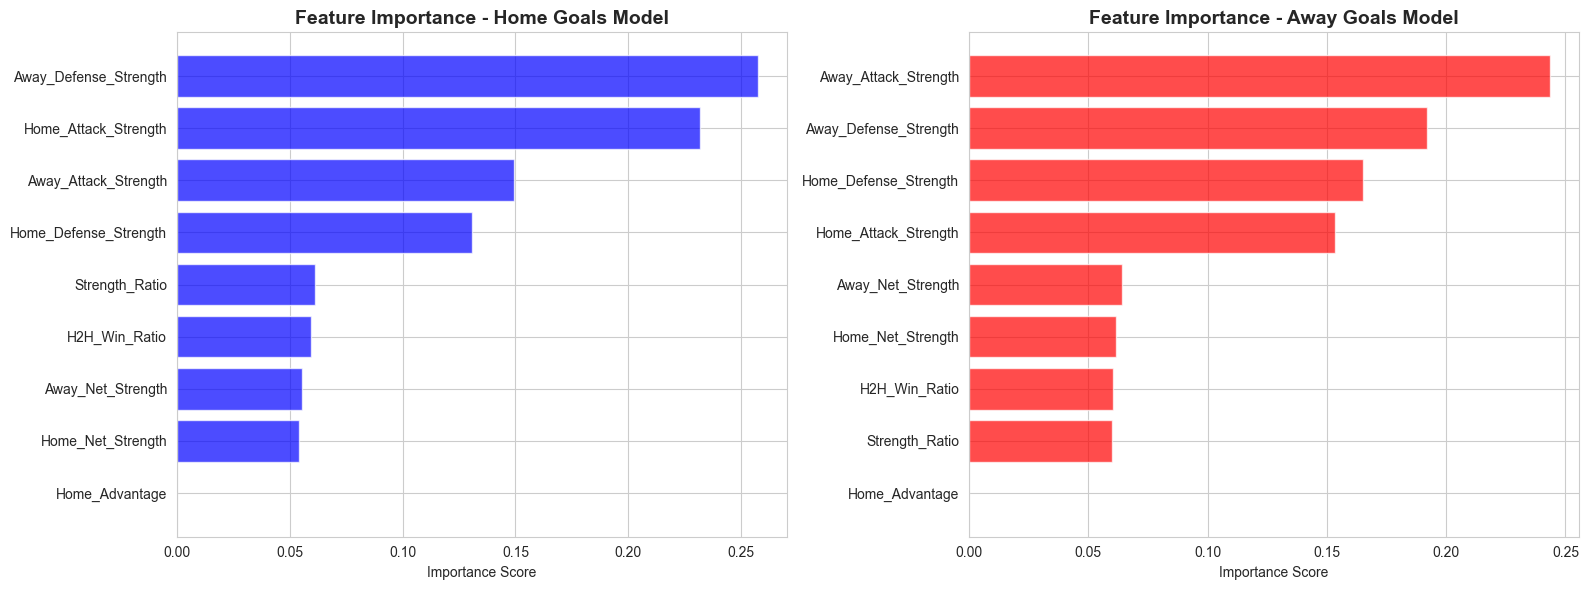

In [23]:
"""
============================================================================
BLOCK 9: FEATURE IMPORTANCE ANALYSIS
============================================================================
"""

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

# Get feature importance
feature_importance_home = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model_home.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_away = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model_away.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nHome Goals Model - Top Features:")
print(feature_importance_home.to_string(index=False))

print("\nAway Goals Model - Top Features:")
print(feature_importance_away.to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(feature_importance_home['Feature'], feature_importance_home['Importance'], color='blue', alpha=0.7)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Feature Importance - Home Goals Model', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

axes[1].barh(feature_importance_away['Feature'], feature_importance_away['Importance'], color='red', alpha=0.7)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Feature Importance - Away Goals Model', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


CREATING VISUALIZATIONS


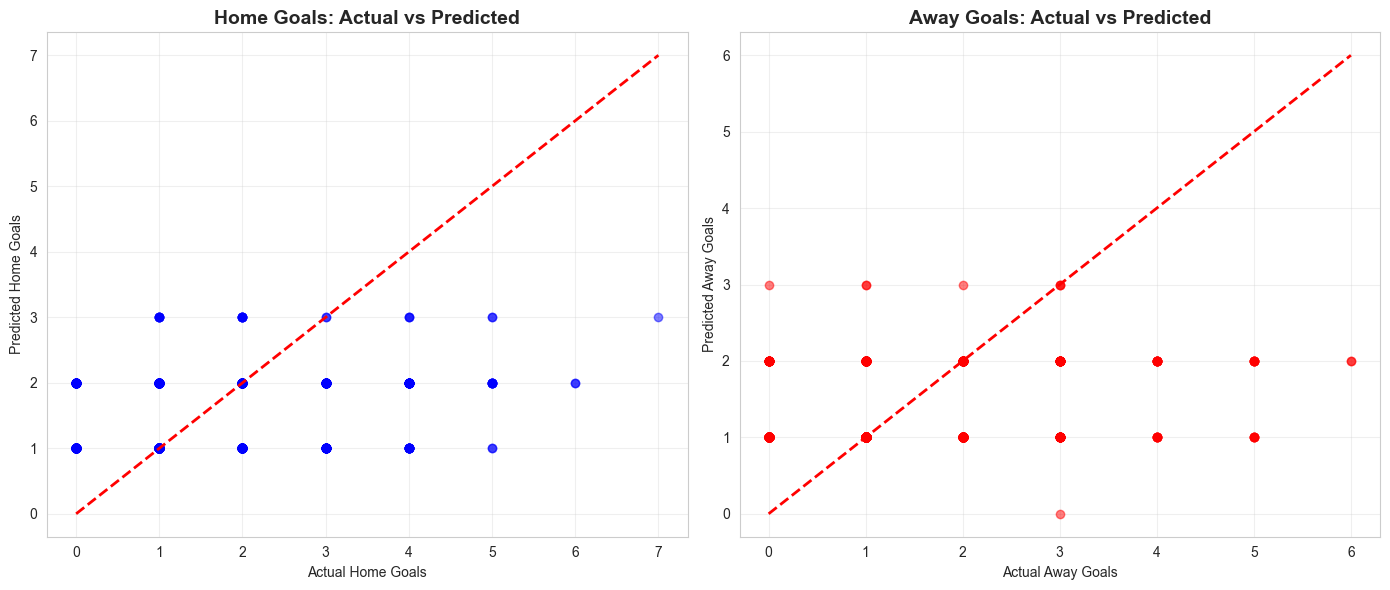

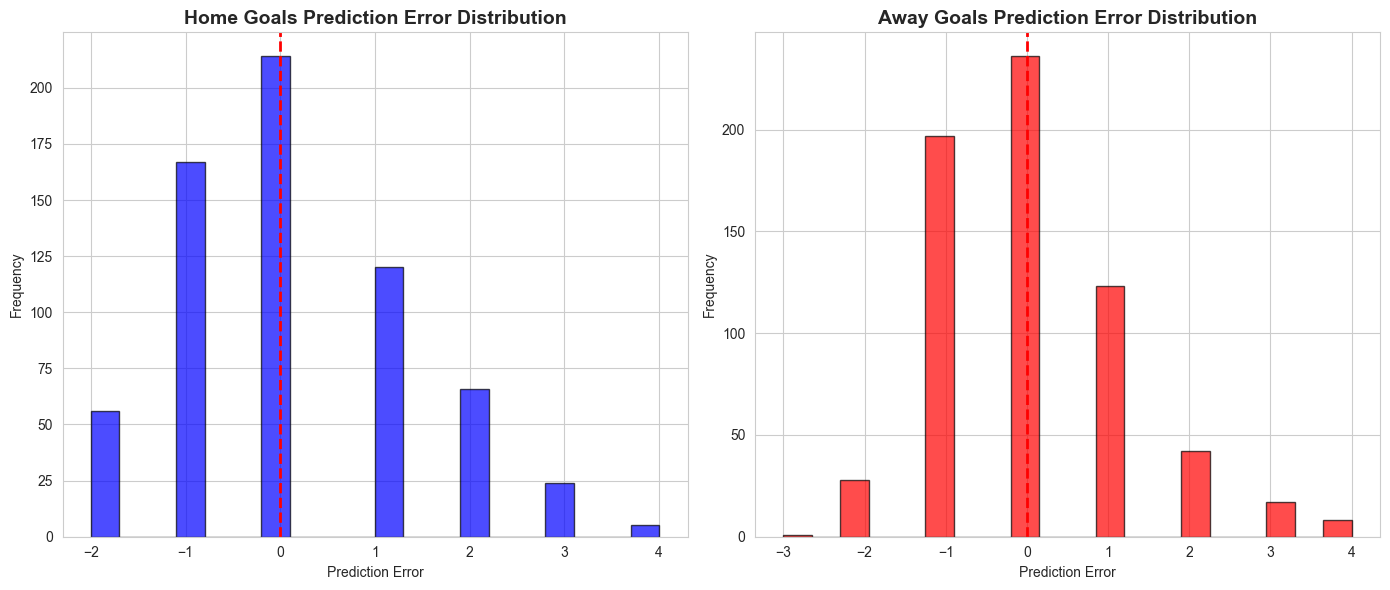

In [24]:
"""
============================================================================
BLOCK 10: PREDICTION VISUALIZATION
============================================================================
"""

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Actual vs Predicted scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_home_test, y_home_pred_rounded, alpha=0.5, color='blue')
axes[0].plot([0, y_home_test.max()], [0, y_home_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Home Goals')
axes[0].set_ylabel('Predicted Home Goals')
axes[0].set_title('Home Goals: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_away_test, y_away_pred_rounded, alpha=0.5, color='red')
axes[1].plot([0, y_away_test.max()], [0, y_away_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Away Goals')
axes[1].set_ylabel('Predicted Away Goals')
axes[1].set_title('Away Goals: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

home_errors = y_home_test.values - y_home_pred_rounded
away_errors = y_away_test.values - y_away_pred_rounded

axes[0].hist(home_errors, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Home Goals Prediction Error Distribution', fontsize=14, fontweight='bold')

axes[1].hist(away_errors, bins=20, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Away Goals Prediction Error Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [25]:
"""
============================================================================
BLOCK 11: SAMPLE PREDICTIONS
============================================================================
"""

print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Show first 10 predictions
results_df = pd.DataFrame({
    'Actual_Home': y_home_test.values[:10],
    'Predicted_Home': y_home_pred_rounded[:10],
    'Actual_Away': y_away_test.values[:10],
    'Predicted_Away': y_away_pred_rounded[:10],
    'Actual_Result': actual_results[:10],
    'Predicted_Result': predicted_results[:10]
})

results_df['Correct'] = results_df['Actual_Result'] == results_df['Predicted_Result']

print("\nFirst 10 Test Predictions:")
print(results_df.to_string(index=False))


SAMPLE PREDICTIONS

First 10 Test Predictions:
 Actual_Home  Predicted_Home  Actual_Away  Predicted_Away Actual_Result Predicted_Result  Correct
         0.0               2          0.0               1             D                H    False
         1.0               1          1.0               2             D                A    False
         1.0               1          1.0               2             D                A    False
         0.0               1          3.0               2             A                A     True
         1.0               1          2.0               1             A                D    False
         3.0               2          2.0               1             H                H     True
         2.0               1          2.0               2             D                A    False
         0.0               1          4.0               2             A                A     True
         0.0               1          3.0               2             

In [26]:
"""
============================================================================
BLOCK 13: PREDICTION FUNCTION FOR NEW MATCHES
============================================================================
"""

def predict_match(home_team_stats, away_team_stats, h2h_ratio=0.5):
    """
    Predict the score for a new match
    
    Parameters:
    -----------
    home_team_stats : dict
        Dictionary with 'attack' and 'defense' keys for home team
    away_team_stats : dict
        Dictionary with 'attack' and 'defense' keys for away team
    h2h_ratio : float
        Head-to-head win ratio for home team (default 0.5)
    
    Returns:
    --------
    tuple : (predicted_home_goals, predicted_away_goals)
    """
    # Create feature vector
    features = np.array([[
        home_team_stats['attack'],
        home_team_stats['defense'],
        away_team_stats['attack'],
        away_team_stats['defense'],
        h2h_ratio,
        home_team_stats['attack'] - away_team_stats['defense'],  # Home_Net_Strength
        away_team_stats['attack'] - home_team_stats['defense'],  # Away_Net_Strength
        (home_team_stats['attack'] + home_team_stats['defense']) / 
        (away_team_stats['attack'] + away_team_stats['defense'] + 0.01)  # Strength_Ratio
    ]])
    
    # Predict
    home_goals = int(np.round(best_model_home.predict(features)[0]))
    away_goals = int(np.round(best_model_away.predict(features)[0]))
    
    # Ensure non-negative
    home_goals = max(0, home_goals)
    away_goals = max(0, away_goals)
    
    return home_goals, away_goals

print("\n" + "="*80)
print("PREDICTION FUNCTION READY")
print("="*80)
print("\nExample usage:")
print("""
home_stats = {'attack': 1.8, 'defense': 1.2}
away_stats = {'attack': 1.5, 'defense': 1.4}
predicted_home, predicted_away = predict_match(home_stats, away_stats, h2h_ratio=0.6)
print(f"Predicted Score: {predicted_home} - {predicted_away}")
""")


PREDICTION FUNCTION READY

Example usage:

home_stats = {'attack': 1.8, 'defense': 1.2}
away_stats = {'attack': 1.5, 'defense': 1.4}
predicted_home, predicted_away = predict_match(home_stats, away_stats, h2h_ratio=0.6)
print(f"Predicted Score: {predicted_home} - {predicted_away}")



In [27]:
"""
============================================================================
PROJECT SUMMARY
============================================================================
"""

print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)
print(f"""
📊 Dataset: {len(df)} matches analyzed
🎯 Models Trained: XGBoost for Home & Away Goals
📈 Match Result Accuracy: {accuracy*100:.2f}%
📉 Home Goals MAE: {mae_home:.4f}
📉 Away Goals MAE: {mae_away:.4f}
""")
print("="*80)


PROJECT SUMMARY

📊 Dataset: 3260 matches analyzed
🎯 Models Trained: XGBoost for Home & Away Goals
📈 Match Result Accuracy: 50.61%
📉 Home Goals MAE: 0.9555
📉 Away Goals MAE: 0.8374

